# Building a 1.46 M cell reference with Symphony

Paper: COVID-19 immune features revealed by a large-scale single-cell transcriptome atlas (Ren et al., Cell, 2021)
https://www.cell.com/cell/pdf/S0092-8674(21)00148-3.pdf

In [2]:
# Import libraries
suppressPackageStartupMessages({
    library(symphony)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(patchwork)
    library(ggthemes)
    library(Matrix)
    library(ggplot2)
    library(plyr)
    library(dplyr)
    library(Seurat)
    library(ggrastr)
    library(ggpubr)
    library(tidyverse)
    library(ggrastr)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

source('../../R/utils.R')

## Read in expression file

In [2]:
barcodes = read.csv('/data/srlab2/jkang/datasets/ren_covid_cell_2021/exp_norm_vargenes_barcodes.csv', header = F)
barcodes %>% head(2)
dim(barcodes)

,V1,V2
,<chr>,<chr>
1,d01_sample_A_AACAGGGGTCGGATTT,d01_sample_A_AACAGGGGTCGGATTT
2,d01_sample_A_AACCAACGTCCGAAAG,d01_sample_A_AACCAACGTCCGAAAG


[1] 1462702       2

Read in expression matrix (.mtx file made in `1_scanpy_preprocessing` notebook)

In [3]:
exp = readMM('/data/srlab2/jkang/datasets/ren_covid_cell_2021/exp_norm_vargenes.mtx')
exp = t(exp)
exp[1:5, 1:5]
dim(exp)

5 x 5 sparse Matrix of class "dgTMatrix"
                            
[1,] .        . . .        .
[2,] .        . . .        .
[3,] .        . . .        .
[4,] 1.072668 . . 0.402389 .
[5,] .        . . .        .

[1]    1301 1462702

Read in variable feature names

In [5]:
features = read.csv('/data/srlab2/jkang/datasets/ren_covid_cell_2021/exp_norm_vargenes_genes.csv', header = FALSE)
rownames(exp) = features$V1
colnames(exp) = barcodes$V1
features %>% head(2)
dim(features)

,V1
,<chr>
1,A2M
2,A2ML1


[1] 1301    1

In [6]:
## Check format of exp matrix
exp[1:5, 1:5]

5 x 5 sparse Matrix of class "dgTMatrix"
       d01_sample_A_AACAGGGGTCGGATTT d01_sample_A_AACCAACGTCCGAAAG
A2M                         .                                    .
A2ML1                       .                                    .
AATK                        .                                    .
ABCA1                       1.072668                             .
ABCA13                      .                                    .
       d01_sample_A_AACCTTTGTAGCACGA d01_sample_A_AAGCATCTCTATCGCC
A2M                                .                      .       
A2ML1                              .                      .       
AATK                               .                      .       
ABCA1                              .                      0.402389
ABCA13                             .                      .       
       d01_sample_A_AATCACGGTCATAAAG
A2M                                .
A2ML1                              .
AATK                               .
ABCA1  

Save exprs as RDS file

In [10]:
# Convert to dgCMatrix
exp = as(exp, "dgCMatrix")
saveRDS(exp, '/data/srlab2/jkang/datasets/ren_covid_cell_2021/exp_norm.rds')

## Make metadata file

In [9]:
metadata_abridged = read.csv('./GSE158055_sample_metadata.csv')
metadata_abridged$dataset = sub("_.*", "", metadata_abridged$characteristics..Meta.sample)
metadata_abridged %>% head(2)

## Remove unneeded columns
metadata_abridged$organism = NULL
metadata_abridged$characteristics..BCR.single.cell.sequencing = NULL
metadata_abridged$characteristics..TCR.single.cell.sequencing = NULL
length(unique(metadata_abridged$Sample.name))

,Sample.name,organism,Patients,characteristics..Meta.sample,characteristics..City,characteristics..Age,characteristics..Sex,characteristics..Sample.type,characteristics..CoVID.19.severity,characteristics..Sample.time,⋯,characteristics..Single.cell.sequencing.platform,characteristics..BCR.single.cell.sequencing,characteristics..TCR.single.cell.sequencing,characteristics..Outcome,characteristics..Comorbidities,characteristics..COVID.19.related.medication.and.anti.microbials,characteristics..Leukocytes..G.L.,characteristics..Neutrophils..G.L.,characteristics..Lymphocytes..G.L.,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,S-S070-1,Homo sapients,P-S070,d01_sample_A,Zhuhai,32,F,frozen PBMC,severe/critical,progression,⋯,10X 3',No,No,discharged,none,"Moxifloxacin, Lopinavir/ ritonavir tablet, Chloroquine",2.8,1.92,0.61,d01
2,S-S070-2,Homo sapients,P-S070,d01_sample_B,Zhuhai,32,F,frozen PBMC,severe/critical,progression,⋯,10X 3',No,No,discharged,none,"Moxifloxacin, Lopinavir/ ritonavir tablet, Chloroquine",2.8,1.92,0.61,d01


[1] 284

In [11]:
cell_annotations = read.csv('/data/srlab2/jkang/datasets/ren_covid_cell_2021/GSE158055_cell_annotation.csv', header = T)
dim(cell_annotations)
cell_annotations = dplyr::rename(cell_annotations, 'Sample.name' = 'sampleID')
cell_annotations %>% head(2)
length(unique(cell_annotations$Sample.name))

[1] 1462702       4

,cellName,Sample.name,celltype,majorType
,<chr>,<chr>,<chr>,<chr>
1,d01_sample_A_AACAGGGGTCGGATTT,S-S070-1,Mono_c1-CD14-CCL3,Mono
2,d01_sample_A_AACCAACGTCCGAAAG,S-S070-1,B_c02-MS4A1-CD27,B


[1] 284

In [12]:
metadata = merge(x = cell_annotations, y = metadata_abridged, by = 'Sample.name', all.x = TRUE)
rownames(metadata) = metadata$cellName
metadata %>% head(3)
dim(metadata)

,Sample.name,cellName,celltype,majorType,Patients,characteristics..Meta.sample,characteristics..City,characteristics..Age,characteristics..Sex,characteristics..Sample.type,⋯,characteristics..Sampling.day..Days.after.symptom.onset.,characteristics..SARS.CoV.2,characteristics..Single.cell.sequencing.platform,characteristics..Outcome,characteristics..Comorbidities,characteristics..COVID.19.related.medication.and.anti.microbials,characteristics..Leukocytes..G.L.,characteristics..Neutrophils..G.L.,characteristics..Lymphocytes..G.L.,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
d08_200177A_H1_AAACCTGAGACCACGA,S-HC001,d08_200177A_H1_AAACCTGAGACCACGA,T_CD4_c01-LEF1,CD4,P-HC001,d08_200177A_H1,Suihua,53,F,CD3+ T cell and CD19+ B cell sorted from fresh PBMC (FACS),⋯,control,negative,10X 5',control,control,control,control,control,control,d08
d08_200177A_H1_AAACCTGAGAGACTAT,S-HC001,d08_200177A_H1_AAACCTGAGAGACTAT,T_CD8_c02-GPR183,CD8,P-HC001,d08_200177A_H1,Suihua,53,F,CD3+ T cell and CD19+ B cell sorted from fresh PBMC (FACS),⋯,control,negative,10X 5',control,control,control,control,control,control,d08
d08_200177A_H1_AAACCTGAGATAGGAG,S-HC001,d08_200177A_H1_AAACCTGAGATAGGAG,B_c02-MS4A1-CD27,B,P-HC001,d08_200177A_H1,Suihua,53,F,CD3+ T cell and CD19+ B cell sorted from fresh PBMC (FACS),⋯,control,negative,10X 5',control,control,control,control,control,control,d08


[1] 1462702      22

Sync cell order in metadata file and expression file

In [13]:
metadata = metadata[colnames(exp), ]
metadata %>% head(2)
all(rownames(metadata) == colnames(exp))

,Sample.name,cellName,celltype,majorType,Patients,characteristics..Meta.sample,characteristics..City,characteristics..Age,characteristics..Sex,characteristics..Sample.type,⋯,characteristics..Sampling.day..Days.after.symptom.onset.,characteristics..SARS.CoV.2,characteristics..Single.cell.sequencing.platform,characteristics..Outcome,characteristics..Comorbidities,characteristics..COVID.19.related.medication.and.anti.microbials,characteristics..Leukocytes..G.L.,characteristics..Neutrophils..G.L.,characteristics..Lymphocytes..G.L.,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
d01_sample_A_AACAGGGGTCGGATTT,S-S070-1,d01_sample_A_AACAGGGGTCGGATTT,Mono_c1-CD14-CCL3,Mono,P-S070,d01_sample_A,Zhuhai,32,F,frozen PBMC,⋯,7,positive,10X 3',discharged,none,"Moxifloxacin, Lopinavir/ ritonavir tablet, Chloroquine",2.8,1.92,0.61,d01
d01_sample_A_AACCAACGTCCGAAAG,S-S070-1,d01_sample_A_AACCAACGTCCGAAAG,B_c02-MS4A1-CD27,B,P-S070,d01_sample_A,Zhuhai,32,F,frozen PBMC,⋯,7,positive,10X 3',discharged,none,"Moxifloxacin, Lopinavir/ ritonavir tablet, Chloroquine",2.8,1.92,0.61,d01


[1] TRUE

Save as metadata file

In [14]:
saveRDS(metadata, '/data/srlab2/jkang/datasets/ren_covid_cell_2021/metadata.rds')

The files we will use to make the reference are `metadata.rds` and `exp_norm.rds`

In the original publication, data was Harmonized over “Sample.name” and “dataset”.

## Mapping with reference/query split dataset

In [22]:
# read in data
exp = readRDS('/data/srlab2/jkang/datasets/ren_covid_cell_2021/exp_norm.rds')
metadata = readRDS('/data/srlab2/jkang/datasets/ren_covid_cell_2021/metadata.rds')

length(unique(metadata$Sample.name))
284 * 0.05 # number of donors to use as query

[1] 284

[1] 14.2

In [23]:
query_samples = sample(unique(metadata$Sample.name), 14) # random donors
query_samples

[1] "S-S076-2"  "S-M004-5"  "S-S021-4"  "S-M009-6"  "S-S061"    "S-M014"   
 [7] "S-M078"    "S-HC010"   "S-S063"    "S-HC017"   "S-HC019-1" "S-S072-3" 
[13] "S-S076-1"  "S-M020"

In [25]:
query_idx = which(metadata$Sample.name %in% query_samples)
query_exp = exp[, query_idx]
query_metadata = metadata[query_idx, ]
dim(query_exp)

[1]  1301 72781

In [29]:
dim(reference_exp)

[1]    1301 1389921

Save reference and query datasets

In [27]:
saveRDS(query_exp, './ref_query_datasets/query_exp_14samples.rds')
saveRDS(query_metadata, './ref_query_datasets/query_meta_14samples.rds')

In [28]:
reference_exp = exp[, -query_idx]
reference_metadata = metadata[-query_idx, ]
saveRDS(reference_exp, 'ref_query_datasets/ref_exp_280samples.rds')
saveRDS(reference_metadata, 'ref_query_datasets/ref_meta_280samples.rds')

Submit job to cluster (script `run_symphony_ref_query_20d.R` in this directory)

In [6]:
prefix = '/data/srlab2/jkang/symphony_reproducibility/runtime/covid19/results/'
avoid_clusters = '-R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\"'

filename = paste0(prefix, 'symphony_1.46M_ref_query_20d.out')
p = paste('bsub', avoid_clusters, '-q big-multi -n 4 -o ', filename, 
          ' -M 100000 -R \'rusage[mem=100000]\' "Rscript run_symphony_ref_query_20d.R', "\"")
print(p)
system(p)

[1] "bsub -R \"select[hname!=cn044]\" -R \"select[hname!=cn045]\" -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -q big-multi -n 4 -o  /data/srlab2/jkang/symphony_reproducibility/runtime/covid19/results/symphony_1.46M_ref_query_20d.out  -M 100000 -R 'rusage[mem=100000]' \"Rscript run_symphony_ref_query_20d.R \""


## Plot reference mapping results

In [3]:
library(RColorBrewer)
brewer.pal(12, 'Paired')

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99" "#B15928"

In [4]:
# Define colors
custom_colors = c('B' = '#A6CEE3',
                 'CD4' = '#1F78B4',
                 'CD8' = '#B2DF8A',
                 'DC' = '#33A02C',
                 'Epi' = '#FB9A99', 
                 'Macro' = '#E31A1C',
                 'Mast' = '#FDBF6F',
                 'Mega' = '#FF7F00',
                 'Mono' = '#CAB2D6',
                 'Neu' = '#6A3D9A',
                 'NK' = '#FFFF99',
                 'Plasma' = '#B15928')

In [5]:
ref270 = readRDS('results/covid19_reference_270samples_20d.rds')
query14 = readRDS('results/covid19_query_14samples_20d.rds')

dim(ref270$meta_data)
dim(query14$meta_data)

[1] 1389921      23

[1] 72781    22

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `majorType`



png 
  2

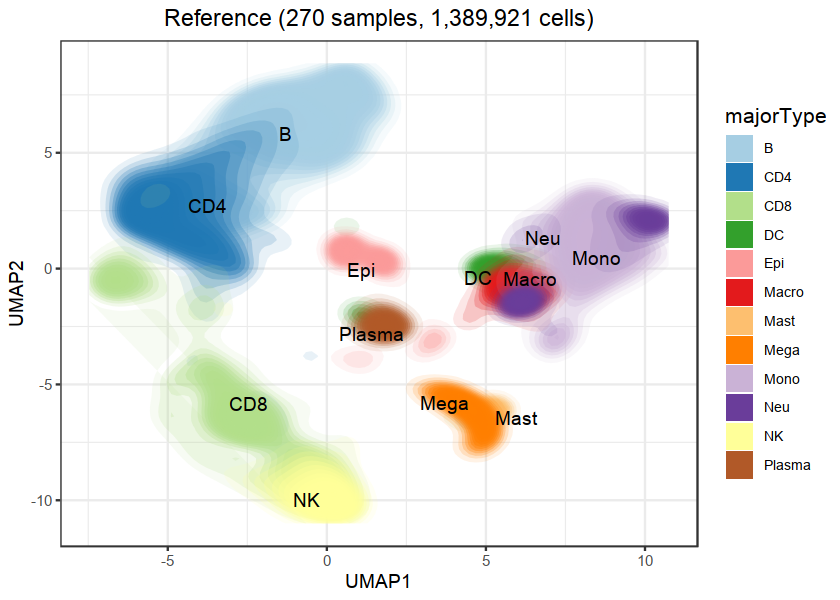

In [6]:
fig.size(5, 7)

p = symphony::plotReference(ref270, color.by = 'majorType',
                as.density = TRUE, celltype.colors = custom_colors, bins = 15) + 
                theme(legend.position = 'right') + ggtitle('Reference (270 samples, 1,389,921 cells)')
pdf('figures/reference_density_20d.pdf', width = 16, height = 8)
print(p)
dev.off()
p

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


png 
  2

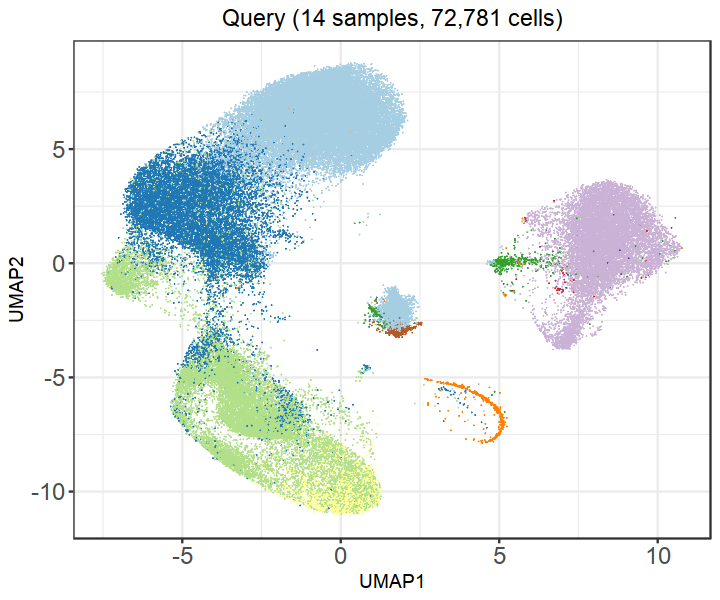

In [7]:
# Visualize of mapping
umap_combined_labels = cbind(query14$meta_data, query14$umap)

fig.size(5, 6)
p = plotBasic(umap_combined_labels, title = 'Query (14 samples, 72,781 cells)', color.by = 'majorType') +
    theme(axis.text.x = element_text(size=14), axis.text.y = element_text(size=14)) +
    theme(legend.position = 'none') + scale_color_manual(values = custom_colors)
pdf('figures/query_mapping_20d.pdf', width = 6, height = 5)
print(p)
dev.off()
p

In [8]:
# Visualize of mapping
# Sync the column names for both data frames
ref270$meta_data$ref_query = 'Reference (270 samples, 1,389,921 cells)'
query14$meta_data$ref_query = 'Query (14 samples, 72,781 cells)'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query14$meta_data, ref270$meta_data)
umap_combined = rbind(query14$umap, ref270$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


png 
  2

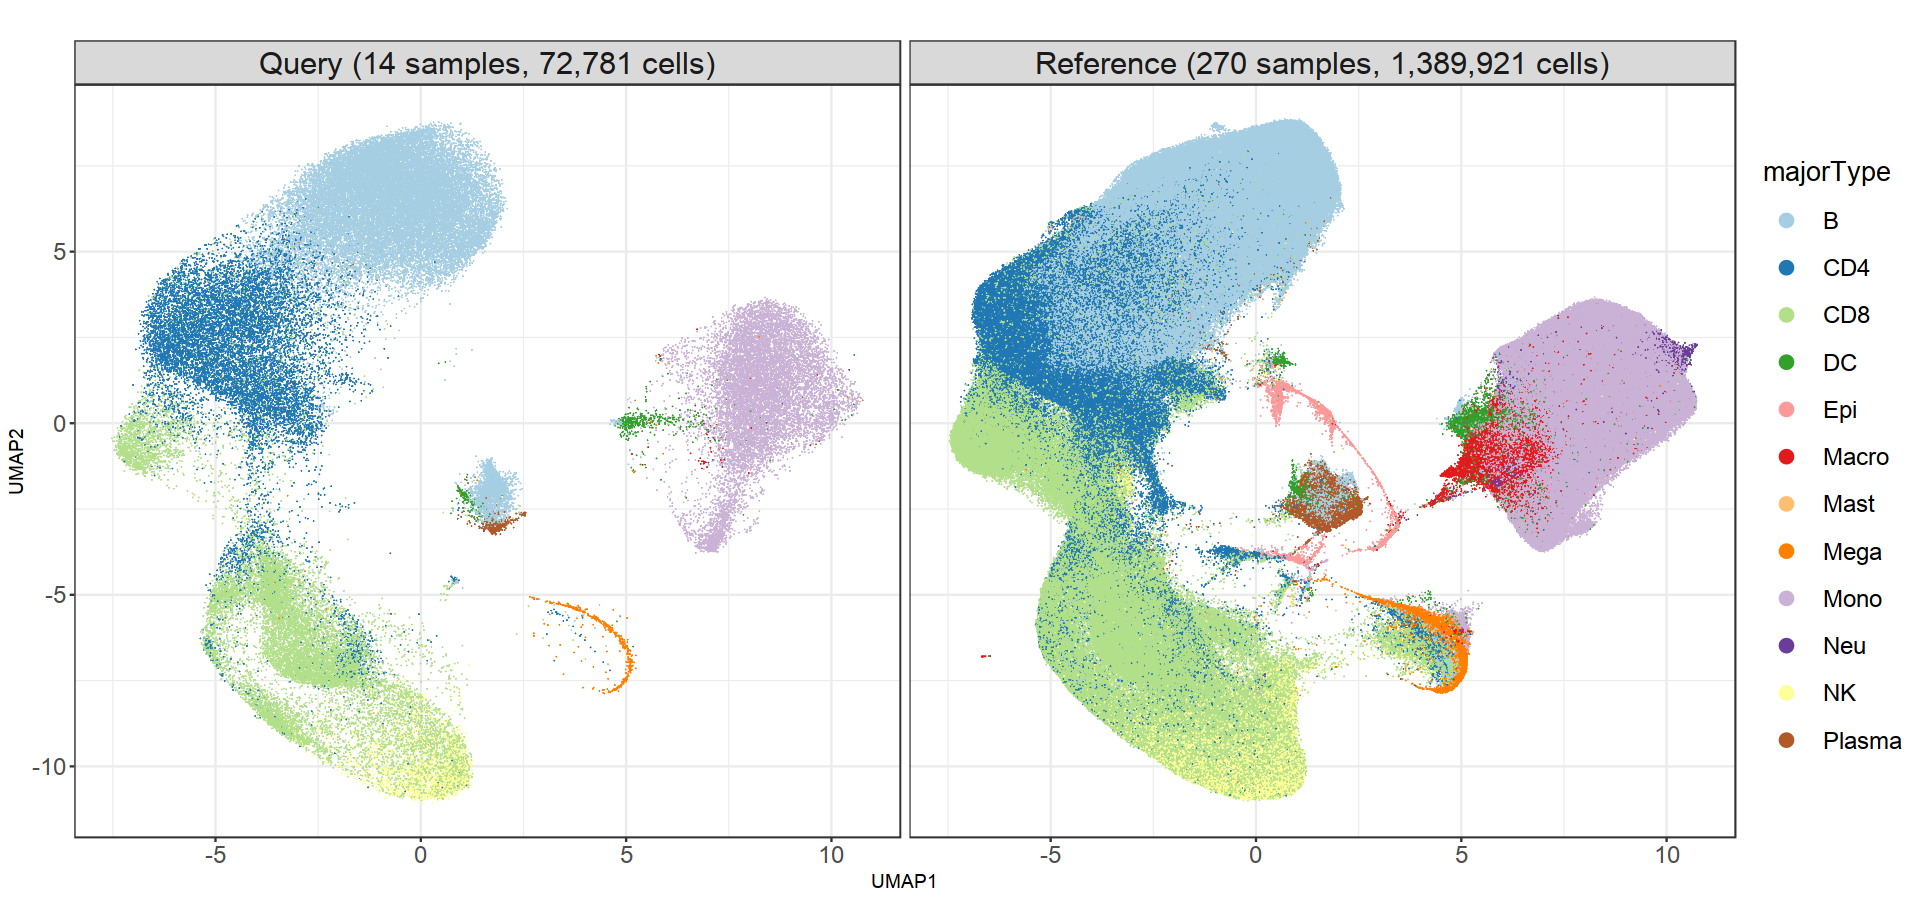

In [9]:
fig.size(7.5, 16)
p = plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'majorType') +
    facet_wrap(~ref_query) + scale_color_manual(values = custom_colors) + theme_bw() +
    theme(axis.text.x = element_text(size=14),
          axis.text.y = element_text(size=14)) +
    theme(strip.text.x = element_text(size = 18)) + ggtitle('') +
    theme(legend.key.size = unit(1, 'cm'), #change legend key size
        legend.key.height = unit(1, 'cm'), #change legend key height
        legend.key.width = unit(1, 'cm'), #change legend key width
        legend.title = element_text(size=16), #change legend title font size
        legend.text = element_text(size=14)) #change legend text font size
pdf('figures/mapping_20d.pdf', width = 16, height = 7.7)
print(p)
dev.off()
p

# Try with spam

Supposedly can handle the 2^32 issue.

https://stackoverflow.com/questions/24236426/how-to-get-a-big-sparse-matrix-in-r-231-1

In [18]:
#install.packages('spam')
#install.packages('spam64')
library(spam)
library(spam64)

In [19]:
exp = spam::read.MM('/data/srlab2/jkang/datasets/ren_covid_cell_2021/GSE158055_covid19_counts.mtx')

ERROR: Error in scan(file, nmax = 1, what = what, quiet = TRUE, ...): scan() expected 'an integer', got '2319108599'


In [20]:
exp = spam64::read.MM('/data/srlab2/jkang/datasets/ren_covid_cell_2021/GSE158055_covid19_counts.mtx')

ERROR: Error: 'read.MM' is not an exported object from 'namespace:spam64'


It seems like seems like `spam` has a `read.MM` function, but it doesn't support 64-bit. There is a `spam64` library, but it doesn't support the `read.MM` function yet.

In [21]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] spam64_2.6-0       spam_2.6-0         dotCall64_1.0-1    ggpubr_0.4.0      
 [5] ggrastr_0.2.3      SeuratObject_4.0.1 Seurat_4.0.2       plyr_1.8.6        
 [9] Matrix_1.3-3       ggthemes_4.2.4     patchwork_1.1.1    matrixStats_0.59.0
[13] data